# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [9]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.0.post2-cp310-cp310-linux_x86_64.whl size=183291101 sha256=16a849d51b95cf8e47a6e6cd36826e9ffbbc068a8546e7e3501a598bd70905a6
  Stored in directory: /root/.cache/pip/wheels/bf/e3/ed/5e845387d52f2debd1bafb847bf3d774d3f0a3c8e31b1dc948
Successfully built flash-attn


## DETR
Here is a minimal implementation of DETR:

In [11]:
from flash_attn import flash_attn_func

In [38]:

class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        self.in_features = 2048
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(self.in_features, hidden_dim, 1)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers,
            custom_encoder=nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers))

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


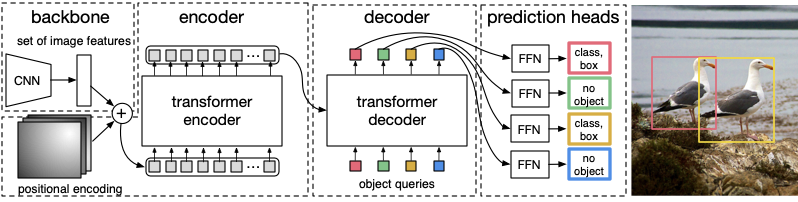

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [17]:
detr = DETRdemo(num_classes=91)
detr.eval();

## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [18]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [19]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Let's put everything together in a `detect` function:

In [30]:

    # Create directories
!mkdir -p /content/coco
!cd /content/coco

    # Download train and val images
!echo "Downloading COCO 2017 Train Images..."
!wget http://images.cocodataset.org/zips/train2017.zip

!echo "Downloading COCO 2017 Validation Images..."
!wget http://images.cocodataset.org/zips/val2017.zip

    # Download annotations
!echo "Downloading COCO 2017 Annotations..."
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

    # Unzip files
!echo "Extracting files..."
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

    # Clean up zip files
!rm train2017.zip val2017.zip annotations_trainval2017.zip

!echo "COCO Dataset downloaded and extracted successfully!"

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/00000052

loading annotations into memory...
Done (t=36.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
COCO Dataset Statistics:
----------------------

Training Set:
Total Images: 118287
Total Annotations: 860001

Validation Set:
Total Images: 5000
Total Annotations: 36781

Object Categories:
person (ID: 1)
bicycle (ID: 2)
car (ID: 3)
motorcycle (ID: 4)
airplane (ID: 5)
bus (ID: 6)
train (ID: 7)
truck (ID: 8)
boat (ID: 9)
traffic light (ID: 10)
fire hydrant (ID: 11)
stop sign (ID: 13)
parking meter (ID: 14)
bench (ID: 15)
bird (ID: 16)
cat (ID: 17)
dog (ID: 18)
horse (ID: 19)
sheep (ID: 20)
cow (ID: 21)
elephant (ID: 22)
bear (ID: 23)
zebra (ID: 24)
giraffe (ID: 25)
backpack (ID: 27)
umbrella (ID: 28)
handbag (ID: 31)
tie (ID: 32)
suitcase (ID: 33)
frisbee (ID: 34)
skis (ID: 35)
snowboard (ID: 36)
sports ball (ID: 37)
kite (ID: 38)
baseball bat (ID: 39)
baseball glove (ID: 40)
skateboard (ID: 41)
surfboard (ID: 42)
tennis 

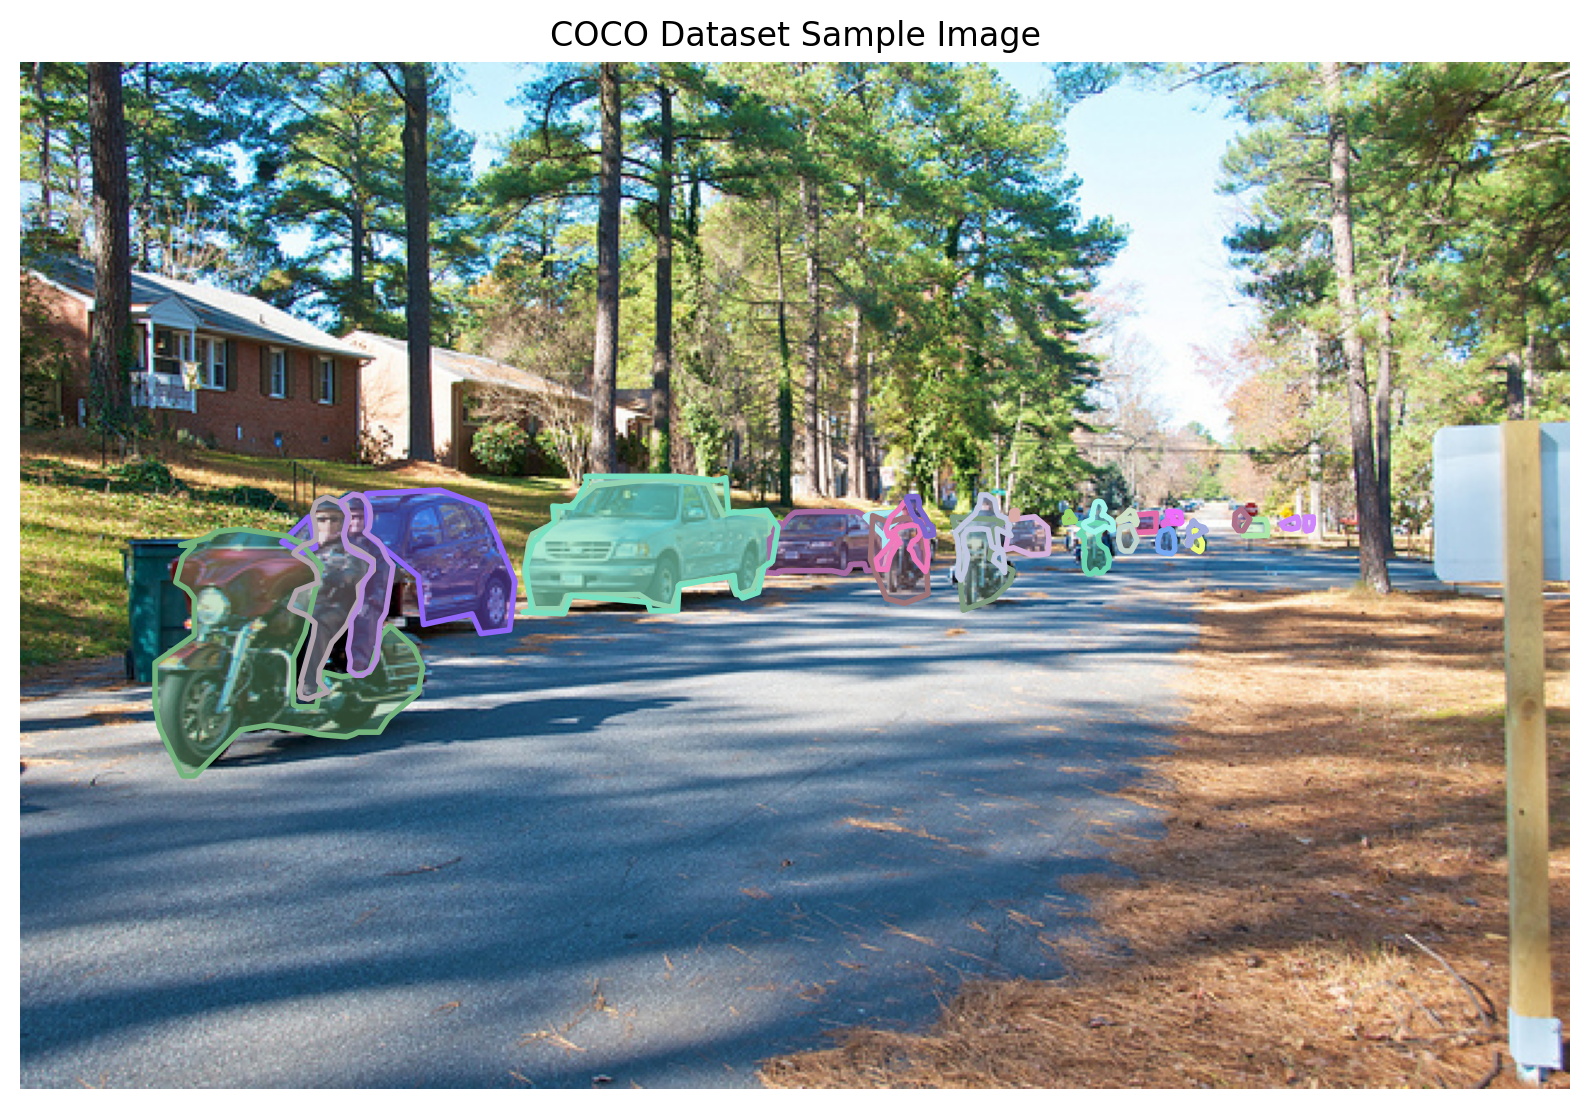

In [32]:


# Python script for verifying and preparing the dataset
import os
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np

def verify_coco_dataset():
    """
    Verify COCO dataset integrity and provide basic statistics
    """
    # Paths for train and val annotations
    train_ann_path = '/content/annotations/instances_train2017.json'
    val_ann_path = '/content/annotations/instances_val2017.json'

    # Create COCO objects
    train_coco = COCO(train_ann_path)
    val_coco = COCO(val_ann_path)

    # Dataset statistics
    print("COCO Dataset Statistics:")
    print("----------------------")

    # Training Set Stats
    print("\nTraining Set:")
    print(f"Total Images: {len(train_coco.imgs)}")
    print(f"Total Annotations: {len(train_coco.anns)}")

    # Validation Set Stats
    print("\nValidation Set:")
    print(f"Total Images: {len(val_coco.imgs)}")
    print(f"Total Annotations: {len(val_coco.anns)}")

    # Category Information
    print("\nObject Categories:")
    categories = train_coco.loadCats(train_coco.getCatIds())
    for cat in categories:
        print(f"{cat['name']} (ID: {cat['id']})")

def visualize_coco_sample(ann_path, img_dir):
    """
    Visualize a random annotated image from COCO dataset

    Args:
        ann_path (str): Path to COCO annotation file
        img_dir (str): Path to image directory
    """
    # Initialize COCO
    coco = COCO(ann_path)

    # Get all image IDs
    img_ids = coco.getImgIds()

    # Select a random image
    import random
    img_id = random.choice(img_ids)

    # Load image information
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])

    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Visualize
    plt.figure(figsize=(10, 8))
    img = plt.imread(img_path)
    plt.imshow(img)

    # Draw bounding boxes
    coco.showAnns(anns)
    plt.axis('off')
    plt.title('COCO Dataset Sample Image')
    plt.show()

# Main execution
if __name__ == '__main__':
    # Download dataset (uncomment if needed)
    # download_coco_dataset()

    # Verify dataset
    verify_coco_dataset()

    # Visualize a sample image
    visualize_coco_sample(
        '/content/annotations/instances_train2017.json',
        '/content/train2017'
    )

# Installation requirements
# Run these in a separate cell
!pip install pycocotools matplotlib

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np
import os
import json
from tqdm import tqdm

class COCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None):
        """
        Custom COCO Dataset loader

        Args:
            root (str): Path to image directory
            annFile (str): Path to COCO annotation file
            transforms (callable, optional): Optional image transformations
        """
        self.root = root
        self.transforms = transforms

        # Load COCO annotations
        with open(annFile, 'r') as f:
            self.coco = json.load(f)

        # Create category mapping
        self.cat_ids = {cat['id']: idx for idx, cat in enumerate(self.coco['categories'])}

        # Prepare image and annotation lists
        self.image_ids = [img['id'] for img in self.coco['images']]
        self.images = {img['id']: img for img in self.coco['images']}

        # Prepare annotations
        self.annotations = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get image ID
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]

        # Load image
        img_path = os.path.join(self.root, img_info['file_name'])
        img = torchvision.io.read_image(img_path)

        # Normalize image
        if img.shape[0] == 1:  # convert grayscale to RGB
            img = img.repeat(3, 1, 1)

        # Apply transforms
        if self.transforms:
            img = self.transforms(img)

        # Prepare target
        annotations = self.annotations.get(img_id, [])

        # Create boxes and labels
        boxes = []
        labels = []
        for ann in annotations:
            # COCO bbox format: [x_min, y_min, width, height]
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])  # convert to [x_min, y_min, x_max, y_max]
            labels.append(self.cat_ids[ann['category_id']])

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        # DETR target format
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
        }

        return img, target

def collate_fn(batch):
    """
    Custom collate function for DETR dataset

    Args:
        batch (list): List of (image, target) tuples

    Returns:
        tuple: Batched images and targets
    """
    return tuple(zip(*batch))

class DETRTrainer:
    def __init__(self, config):
        """
        DETR Model Trainer

        Args:
            config (dict): Configuration dictionary
        """
        self.config = config

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Data transformations
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((800, 1333)),  # DETR default input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Create datasets
        self.train_dataset = COCODataset(
            root=config['train_img_dir'],
            annFile=config['train_ann_file'],
            transforms=self.transform
        )

        self.val_dataset = COCODataset(
            root=config['val_img_dir'],
            annFile=config['val_ann_file'],
            transforms=self.transform
        )

        # DataLoaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=config.get('num_workers', 4)
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=config.get('num_workers', 4)
        )

        # Model initialization
        self.model = self._initialize_model(len(self.train_dataset.cat_ids) + 1)
        self.model.to(self.device)

        # Optimizer and LR scheduler
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config.get('learning_rate', 1e-4),
            weight_decay=config.get('weight_decay', 1e-4)
        )

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=config.get('lr_step_size', 30),
            gamma=config.get('lr_gamma', 0.1)
        )

    def _initialize_model(self, num_classes):
        """
        Initialize DETR model with custom number of classes

        Args:
            num_classes (int): Number of object classes

        Returns:
            torch.nn.Module: Configured DETR model
        """
        model = DETRdemo(num_classes=num_classes)

        # Modify classifier for custom number of classes
        in_features = model.in_features
        model.class_embed = nn.Linear(in_features, num_classes)

        return model

    def train_epoch(self):
        """
        Train model for one epoch

        Returns:
            float: Average loss for the epoch
        """
        self.model.train()
        total_loss = 0

        for images, targets in tqdm(self.train_loader, desc='Training'):
            # Move to device
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            loss_dict = self.model.forward(images)

            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass
            losses.backward()
            self.optimizer.step()

            total_loss += losses.item()

        # Learning rate scheduler step
        self.scheduler.step()

        return total_loss / len(self.train_loader)

    def validate(self):
        """
        Validate model performance

        Returns:
            float: Average validation loss
        """
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, targets in tqdm(self.val_loader, desc='Validation'):
                # Move to device
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                # Forward pass
                loss_dict = self.model(images, targets)

                # Compute total loss
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

        return total_loss / len(self.val_loader)

    def train(self, num_epochs):
        """
        Full training loop

        Args:
            num_epochs (int): Number of training epochs
        """
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            # Train for one epoch
            train_loss = self.train_epoch()

            # Validate
            val_loss = self.validate()

            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }, self.config.get('save_path', 'detr_best_model.pth'))

    def inference(self, image_path, confidence_threshold=0.5):
        """
        Run inference on a single image

        Args:
            image_path (str): Path to input image
            confidence_threshold (float): Confidence threshold for detections

        Returns:
            dict: Detected objects with their bounding boxes and labels
        """
        self.model.eval()

        # Load and transform image
        image = torchvision.io.read_image(image_path)
        transformed_image = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            predictions = self.model.forward(transformed_image)[0]

        # Process predictions
        boxes = predictions['boxes'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()

        # Filter by confidence
        mask = scores > confidence_threshold
        boxes = boxes[mask]
        labels = labels[mask]
        scores = scores[mask]

        return {
            'boxes': boxes,
            'labels': labels,
            'scores': scores
        }

# Example configuration
config = {
    'train_img_dir': '/content/train2017',
    'train_ann_file': '/content/annotations/instances_train2017.json',
    'val_img_dir': '/content/val2017',
    'val_ann_file': '/content/annotations/instances_val2017.json',
    'batch_size': 4,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'num_workers': 4,
    'save_path': 'detr_best_model.pth'
}

# Training script
def main():
    # Initialize trainer
    trainer = DETRTrainer(config)

    # Train the model
    trainer.train(num_epochs=50)

    # Optional: Run inference on a test image
    # inference_result = trainer.inference('/path/to/test/image.jpg')
    # print(inference_result)

main()

In [20]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

## Using DETR
To try DETRdemo model on your own image just change the URL below.

In [21]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

Let's now visualize the model predictions

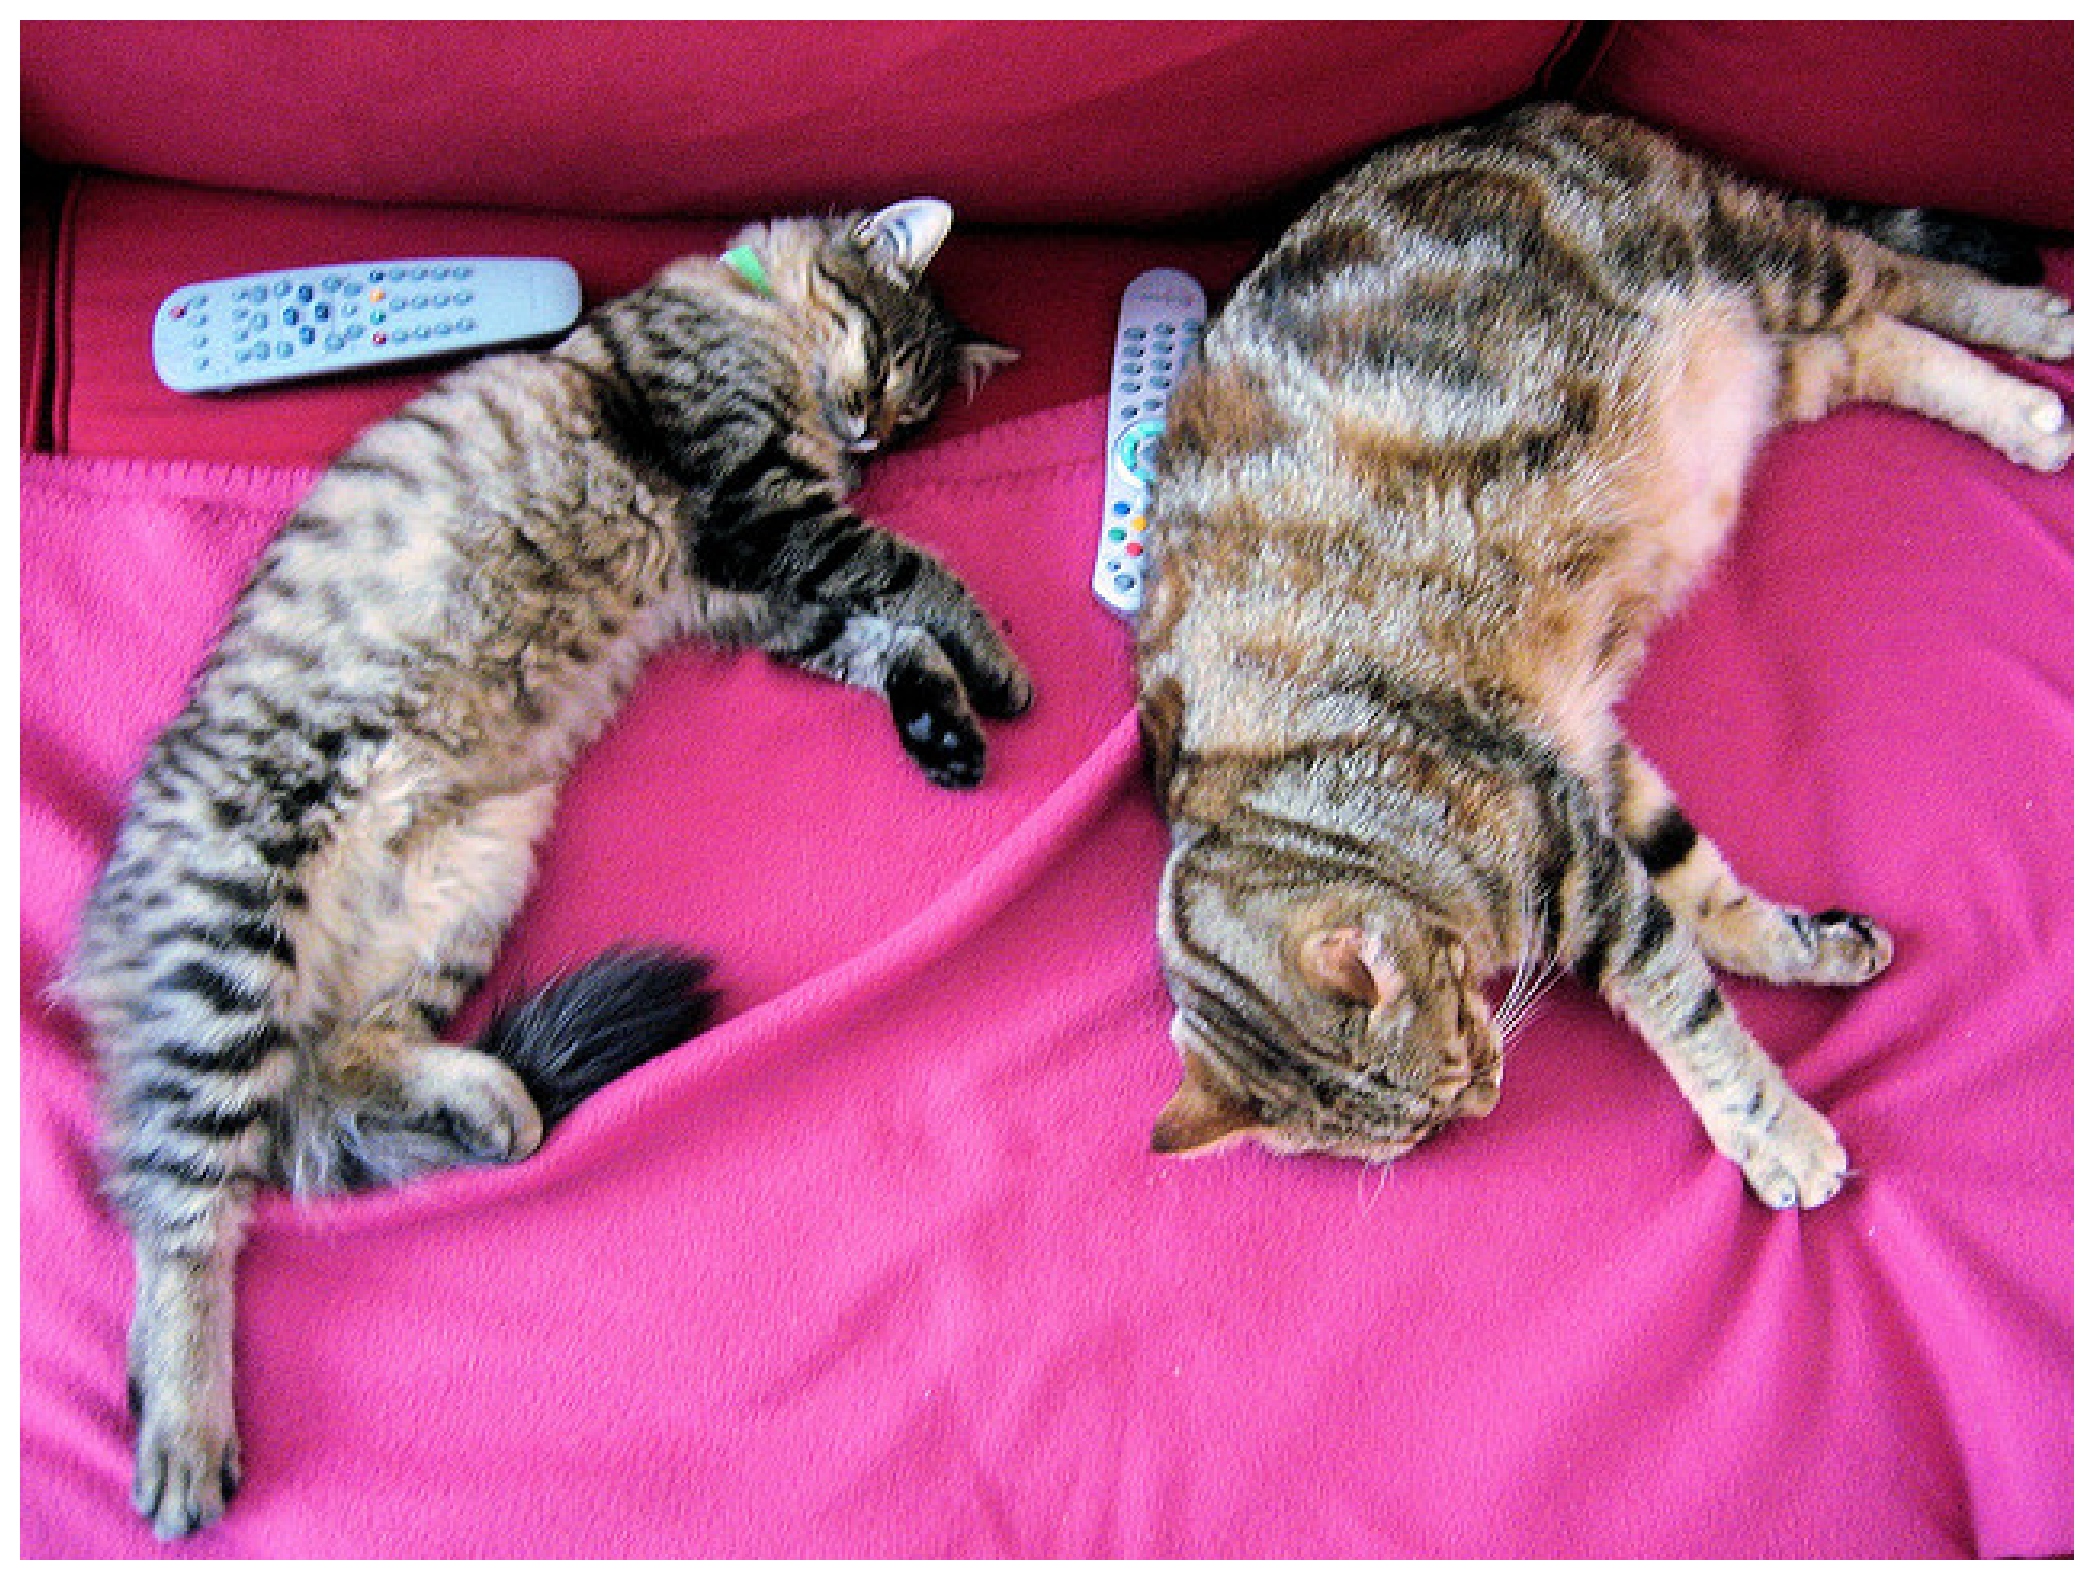

In [22]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)